### Study of Reinforcement Learning Policy Gradient method in  OpenAI Gym environment - CartPole.

In [18]:
import gym

import numpy as np
import torch
import torch.nn
import torch.nn.functional as F
from torch.autograd import Variable

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
def basic_policy(obs):
    """ Return action code: 
            1: accelerate right
            0: accelerate left 
        Parameters:
        obs ::= (horizontal pos, velocity, angle, angular velocity)
        
        Policy is as follows:
        If pole is approximately vertical - |theta| < 0.05:
          - accelerate left if angular velocity is negative (to the right)
          - accelerate right if angular velocity is positive (to the left)
        else:
          - accelerate left if pole is in right quadrant
          - accelerate right if pole is in left quadrant
        
    """
    theta = obs[2]
    theta_p = obs[3]
    if np.abs(theta) < 0.05:
        return 0 if theta_p < 0 else 1
    else:
        return 0 if theta < 0 else 1
        

In [28]:
def experiment(env, num_episodes, policy):
    """
        Return tuple: average reward, min reward, max reward.
    """
    acc = []
    for ep in range(num_episodes):
        rewards = 0
        obs = env.reset()
        for step in range(1000):
            action = policy(obs)
            obs, reward, done, info = env.step(action)
            rewards += reward
            if done:
                break
        acc.append(rewards)
    return np.mean(acc), np.min(acc), np.max(acc)

In [30]:
env = gym.make('CartPole-v1')
experiment(env, 1000, basic_policy)

(243.853, 171.0, 500.0)

### Train Neural Network using Policy Gradient Reinforcement Learning  to balance Cart-Pole.

Resources:
- __[RL Course by David Silver — Lecture 7: Policy Gradient Methods](https://www.youtube.com/watch?v=KHZVXao4qXs&feature=youtu.be)__ — David Silver
- __[Deep Reinforcement Learning: Pong from Pixels](http://karpathy.github.io/2016/05/31/rl/)__ — Andrej Karpathy
- __[Policy Gradient Reinforcement Learning in PyTorch](https://medium.com/@ts1829/policy-gradient-reinforcement-learning-in-pytorch-df1383ea0baf)__ - Tim


In [22]:
class NNController(torch.nn.Module):
    accelerate_left = 1
    accelerate_right = 0
    
    def __init__(self, input_size, hidden_size):
        super(NNController, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size, bias=False)
        self.fc2 = torch.nn.Linear(hidden_size, 1, bias=False)
        self.policy_history = []
        self.reward_history = []
        
    def fit(self, env, num_episodes, learn_rate, gamma):
        """ Train NN controller to balance cart-pole system.
            
            Parameters
            ----------
            env ::= game - CartPole - environment.
            num_episodes ::= max number of train episodes.
            learn_rate   ::= learning rate to update weights of NN (optimizer learning rate)
            gamma        ::= discount rate to calculate total reward for a step.
        """    
        self.optimizer  = torch.optim.Adam(self.parameters(), lr=learn_rate)

        running_reward = 10
        for episode in range(num_episodes):
            self.train()
            rewards = []
            state = env.reset()
            for step in range(1000):
                action = self._select_action(state)
                state, reward, done, _ = env.step(action)
                rewards.append(reward)
                if done:
                    break
            self._update_policy(rewards, gamma)
            self.reward_history.append(np.sum(rewards))
            
            # Used to determine when the environment is solved.
            running_reward = running_reward * 0.99 + step * 0.01
            if episode % 50 == 0:
                print('Episode {}\tLast run: {}\tAverage reward: {:.2f}'.format(episode, step, running_reward))

            if running_reward > env.spec.reward_threshold:
                print("Solved! Running reward is now {} and the last episode runs to {} time steps!".format(running_reward, step))
                break             
    
    def forward(self, x):
        """ Forward pass returns probability
            of accelerating to the left: action == 1
        """
        h = F.relu(self.fc1(x))
        output = self.fc2(h)
        y_hat = torch.sigmoid(output)
        return y_hat
    
    def predict(self, x):
        """ Retun action code: [0, 1].
            
            Use trained model to predict action based on specified state.
        """
        self.eval()
        with torch.no_grad():
            state = torch.from_numpy(x).type(torch.FloatTensor)
            y_hat = self.forward(state)
            return NNController.accelerate_left if y_hat > 0.5 else NNController.accelerate_right
        
    def _select_action(self, state):
        """ Select action stochastically.
        """
        state = torch.from_numpy(state).type(torch.FloatTensor)
        y_hat = self.forward(state)
        y = 1 if np.random.random() < y_hat else 0
        action = NNController.accelerate_left if y else NNController.accelerate_right
        logprob = torch.log(y_hat) if y else torch.log(1-y_hat) 
        self.policy_history.append(logprob)
        return action
    
    def _update_policy(self, policy_rewards, gamma):
        """ Backpropagate policy gradient to update 
            controller's weights.
        """
        eps = np.finfo(np.float32).eps.item()
        R = 0
        rewards = []
        for pos, r in enumerate(policy_rewards[::-1]):
            R = r + gamma * R
            rewards.insert(0, R)
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std() + eps)
        loss = torch.cat([-log_prob*reward for log_prob, reward in zip(self.policy_history, rewards)]).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.policy_history = []



In [23]:
env = gym.make('CartPole-v1')
nn = NNController(4, 32)
nn.fit(env, 50000, 0.001, 0.99)

Episode 0	Last run: 11	Average reward: 10.01
Episode 50	Last run: 18	Average reward: 15.36
Episode 100	Last run: 36	Average reward: 19.08
Episode 150	Last run: 29	Average reward: 21.86
Episode 200	Last run: 25	Average reward: 23.99
Episode 250	Last run: 18	Average reward: 23.66
Episode 300	Last run: 30	Average reward: 27.49
Episode 350	Last run: 47	Average reward: 29.97
Episode 400	Last run: 23	Average reward: 32.49
Episode 450	Last run: 63	Average reward: 35.21
Episode 500	Last run: 21	Average reward: 37.11
Episode 550	Last run: 28	Average reward: 40.61
Episode 600	Last run: 66	Average reward: 45.81
Episode 650	Last run: 79	Average reward: 50.53
Episode 700	Last run: 104	Average reward: 59.61
Episode 750	Last run: 79	Average reward: 68.78
Episode 800	Last run: 51	Average reward: 79.25
Episode 850	Last run: 89	Average reward: 84.65
Episode 900	Last run: 49	Average reward: 100.49
Episode 950	Last run: 178	Average reward: 122.13
Episode 1000	Last run: 274	Average reward: 150.19
Episode 1

#### Plot training progress.

In [24]:
def plot_training_progress(rewards, window):
    """ Plot episodes duration moving average.
        Parameters
        ==========
        rewards ::= collection of rewards per episode, where
                    episode's rewards define number of steps / duration.
        window  ::= moving average window.
    """
    fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9,9]);
    moving_average = pd.Series(rewards).rolling(window).mean()
    sigma = pd.Series(rewards).rolling(window).std()
    ax1.plot(moving_average)
    ax1.fill_between(range(len(rewards)), moving_average-sigma, moving_average+sigma, color='blue', alpha=0.1)
    ax1.set_title('Moving Average of Episode Duration ({}-episode window)'.format(window))
    ax1.set_xlabel('Episode'); ax1.set_ylabel('Duration')

    ax2.plot(rewards)
    ax2.set_title('Episode duration')
    ax2.set_xlabel('Episode'); ax2.set_ylabel('Duration')

    fig.tight_layout(pad=2)
    plt.show()    
    

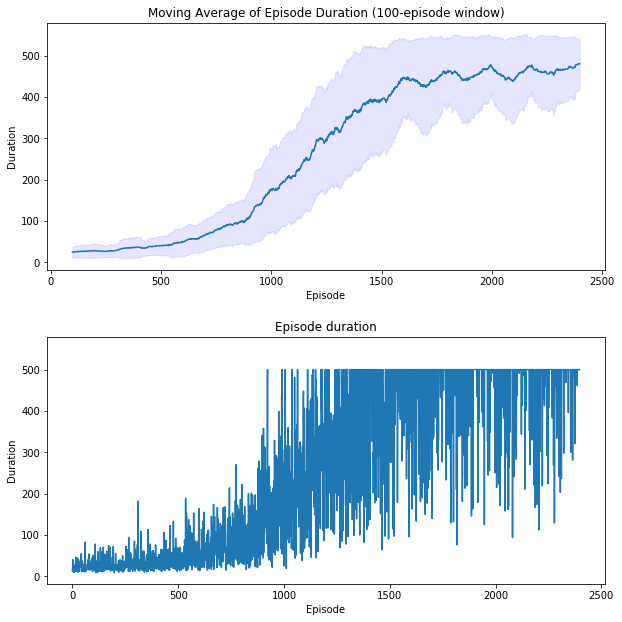

In [25]:
plot_training_progress(nn.reward_history, 100)

#### Play the game using trained controller.

In [26]:
env = gym.make('CartPole-v1')
for tryout in range(5):
    state = env.reset()
    for step in range(1000):
        action = nn.predict(state)
        state, _, done, _ = env.step(action)
        if done:
            break
    print("Tryout={} steps={}".format(tryout, step))
   

Tryout=0 steps=499
Tryout=1 steps=499
Tryout=2 steps=499
Tryout=3 steps=499
Tryout=4 steps=499
